In [1]:
import logging
import os
import random
import sys
from collections import deque

sys.path.insert(0, './')

In [2]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import tensorflow.contrib.slim as slim
from nets.mobilenet import mobilenet_v2

BATCH_SIZE = 32
IMAGE_SIZE = 224

checkpoint_name = './mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt'

tf.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'1.15.0'

In [3]:
def set_random_seed():
    seed = random.randrange(2 ** 32 - 2)
    logging.info('Using random seed {}'.format(seed))
    random.seed(seed)
    np.random.seed(seed + 1)
    tf.set_random_seed(seed + 2)
    
set_random_seed()

In [4]:
from dataset_factory import ImageCollector, ImgInverNormalize
import matplotlib.pyplot as plt
from matplotlib import cm

In [5]:
dataset = ImageCollector("./ARVision Data", 1, 100, 32) # Real data
dataset.StartLoadData()

module name: dataset_factory
parent process: 6811
process id: 14705


In [6]:
train_data = dataset.getLoadedData()

max : 1.0
min : -0.9294117647058824


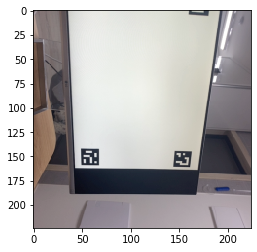

In [7]:
print("max : " + str(train_data[1][0].max()))
print("min : " + str(train_data[1][0].min()))

plt.imshow(ImgInverNormalize(train_data[1][0], 1.))
# plt.imshow(train_data[1][0])
plt.show()

In [8]:
input_img = tf.placeholder(tf.float32, [None] + [IMAGE_SIZE, IMAGE_SIZE, 3])
input_label = tf.placeholder(tf.float32, [None] + [6])

In [9]:
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
    logits, endpoints = mobilenet_v2.mobilenet(input_img, num_classes=6)

Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="MobilenetV2")
reuse_var_refine = [var for var in reuse_vars if '6DOF' not in var.name]

saver = tf.train.Saver(var_list=reuse_var_refine)
new_saver = tf.train.Saver()

In [11]:
with sess.as_default():
    train_data = dataset.getLoadedData()
    saver.restore(sess, checkpoint_name)
    x = endpoints['6DOF'].eval(feed_dict={input_img: train_data[1]})

INFO:tensorflow:Restoring parameters from ./mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt


INFO:tensorflow:Restoring parameters from ./mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt


In [12]:
x[0]

array([-0.13362785, -0.0693365 ,  0.23909086, -0.05283219, -0.07301038,
       -0.10813985], dtype=float32)

# Save Trained Model

In [13]:
save_dir = './checkpoints'
save_path = os.path.join(save_dir, 'model.ckpt')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_path = new_saver.save(sess, save_path)
tf.train.write_graph(sess.graph, './', 'model.pbtxt')

'./model.pbtxt'

# Tensorflow to CoreML

In [14]:
from tensorflow.python.tools.freeze_graph import freeze_graph
import tfcoreml
import coremltools
from PIL import Image

In [16]:
# Provide these to run freeze_graph:
# Graph definition file, stored as protobuf TEXT
graph_def_file = './model.pbtxt'
# Trained model's checkpoint name
checkpoint_file = './checkpoints/model.ckpt'
# Frozen model's output name
frozen_model_file = './frozen_model.pb'
# Output nodes. If there're multiple output ops, use comma separated string, e.g. "out1,out2".
output_node_names = 'MobilenetV2/Logits/6DOF' 


# Call freeze graph
freeaed = freeze_graph(input_graph=graph_def_file,
                       input_saver="",
                       input_binary=False,
                       input_checkpoint=checkpoint_file,
                       output_node_names=output_node_names,
                       restore_op_name="save/restore_all",
                       filename_tensor_name="save/Const:0",
                       output_graph=frozen_model_file,
                       clear_devices=True,
                       initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt


INFO:tensorflow:Froze 262 variables.


INFO:tensorflow:Froze 262 variables.


INFO:tensorflow:Converted 262 variables to const ops.


INFO:tensorflow:Converted 262 variables to const ops.


In [41]:
"""
Step 2: Call converter
"""

# Provide these inputs in addition to inputs in Step 1
# A dictionary of input tensors' name and shape (with batch)
IMAGE_INPUT_NAME = ["Placeholder"]
input_tensor_shapes = {"Placeholder":[1,224,224,3]} # batch size is 1
# Output CoreML model path
coreml_model_file = './AR3DVision.mlmodel'
output_tensor_names = ['MobilenetV2/Logits/6DOF']


# Call the converter
# coreml_model = tfcoreml.convert(
#     tf_model_path=frozen_model_file, 
#     mlmodel_path=coreml_model_file, 
#     input_name_shape_dict=input_tensor_shapes,
#     output_feature_names=output_tensor_names,
#     minimum_ios_deployment_target='13')

coreml_model = tfcoreml.convert(
    tf_model_path=frozen_model_file, 
    mlmodel_path=coreml_model_file,
    image_input_names=IMAGE_INPUT_NAME,
    input_name_shape_dict=input_tensor_shapes,
    output_feature_names=output_tensor_names,
    minimum_ios_deployment_target='13',
    image_scale=2.0/255.0,
    red_bias=-1,
    green_bias=-1,
    blue_bias=-1)

0 assert nodes deleted
262 nodes deleted
156 nodes deleted
0 nodes deleted
[Op Fusion] fuse_bias_add() deleted 2 nodes.
2 identity nodes deleted
36 disconnected nodes deleted
[Op Fusion] Fused 312 nodes into BatchNorms.
[SSAConverter] Converting function main ...
[SSAConverter] [1/172] Converting op type: 'Placeholder', name: 'Placeholder', output_shape: (1, 224, 224, 3).
[SSAConverter] [2/172] Converting op type: 'Const', name: 'MobilenetV2/expanded_conv/depthwise/depthwise_weights/read', output_shape: (3, 3, 32, 1).
[SSAConverter] [3/172] Converting op type: 'Const', name: 'MobilenetV2/expanded_conv_1/depthwise/depthwise_weights/read', output_shape: (3, 3, 96, 1).
[SSAConverter] [4/172] Converting op type: 'Const', name: 'MobilenetV2/expanded_conv_2/depthwise/depthwise_weights/read', output_shape: (3, 3, 144, 1).
[SSAConverter] [5/172] Converting op type: 'Const', name: 'MobilenetV2/expanded_conv_3/depthwise/depthwise_weights/read', output_shape: (3, 3, 144, 1).
[SSAConverter] [6/172

[SSAConverter] [67/172] Converting op type: 'Relu6', name: 'MobilenetV2/expanded_conv_5/depthwise/Relu6', output_shape: (1, 192, 28, 28).
[SSAConverter] [68/172] Converting op type: 'Conv2D', name: 'MobilenetV2/expanded_conv_5/project/Conv2D', output_shape: (1, 32, 28, 28).
[SSAConverter] [69/172] Converting op type: 'BatchNorm', name: 'MobilenetV2/expanded_conv_5/project/BatchNorm/FusedBatchNormV3/Add_batch_norm', output_shape: (1, 32, 28, 28).
[SSAConverter] [70/172] Converting op type: 'AddV2', name: 'MobilenetV2/expanded_conv_5/add', output_shape: (1, 32, 28, 28).
[SSAConverter] [71/172] Converting op type: 'Conv2D', name: 'MobilenetV2/expanded_conv_6/expand/Conv2D', output_shape: (1, 192, 28, 28).
[SSAConverter] [72/172] Converting op type: 'BatchNorm', name: 'MobilenetV2/expanded_conv_6/expand/BatchNorm/FusedBatchNormV3/Add_batch_norm', output_shape: (1, 192, 28, 28).
[SSAConverter] [73/172] Converting op type: 'Relu6', name: 'MobilenetV2/expanded_conv_6/expand/Relu6', output_sha

[SSAConverter] [141/172] Converting op type: 'BatchNorm', name: 'MobilenetV2/expanded_conv_14/expand/BatchNorm/FusedBatchNormV3/Add_batch_norm', output_shape: (1, 960, 7, 7).
[SSAConverter] [142/172] Converting op type: 'Relu6', name: 'MobilenetV2/expanded_conv_14/expand/Relu6', output_shape: (1, 960, 7, 7).
[SSAConverter] [143/172] Converting op type: 'DepthwiseConv2dNative', name: 'MobilenetV2/expanded_conv_14/depthwise/depthwise', output_shape: (1, 960, 7, 7).
[SSAConverter] [144/172] Converting op type: 'BatchNorm', name: 'MobilenetV2/expanded_conv_14/depthwise/BatchNorm/FusedBatchNormV3/Add_batch_norm', output_shape: (1, 960, 7, 7).
[SSAConverter] [145/172] Converting op type: 'Relu6', name: 'MobilenetV2/expanded_conv_14/depthwise/Relu6', output_shape: (1, 960, 7, 7).
[SSAConverter] [146/172] Converting op type: 'Conv2D', name: 'MobilenetV2/expanded_conv_14/project/Conv2D', output_shape: (1, 160, 7, 7).
[SSAConverter] [147/172] Converting op type: 'BatchNorm', name: 'MobilenetV2/e

In [42]:
# Test CoreML convert result
formatted = (ImgInverNormalize(train_data[1][0], 255).astype('uint8'))
# coreml_test_data = train_data[1][0][np.newaxis,:]
coreml_test_data = Image.fromarray(formatted)
coreml_inputs = {'Placeholder': coreml_test_data} # (batch=1,W=224, H=224, C=3)
coreml_output = coreml_model.predict(coreml_inputs, useCPUOnly=True)

print("label : ", train_data[2][0])
print(x[0])
print(coreml_output)

label :  [ 0.0169601 -0.0543071  0.603348  -2.19219   -2.07341   -0.298648 ]
[-0.13362785 -0.0693365   0.23909086 -0.05283219 -0.07301038 -0.10813985]
{'MobilenetV2/Logits/6DOF': array([[-0.12682924, -0.0862437 ,  0.22256055, -0.04865033, -0.05427179,
        -0.10165223]], dtype=float32)}


# CoreML Preprocess info

In [40]:
from coremltools.proto import FeatureTypes_pb2 as _FeatureTypes_pb2

spec = coremltools.models.utils.load_spec(coreml_model_file)
print(spec.WhichOneof('Type'))
if spec.WhichOneof('Type') == 'neuralNetworkClassifier':
  nn = spec.neuralNetworkClassifier
if spec.WhichOneof('Type') == 'neuralNetwork':
  nn = spec.neuralNetwork  
if spec.WhichOneof('Type') == 'neuralNetworkRegressor':
  nn = spec.neuralNetworkRegressor

preprocessing = nn.preprocessing[0].scaler
print( 'channel scale: ', preprocessing.channelScale)
print( 'blue bias: ', preprocessing.blueBias)
print( 'green bias: ', preprocessing.greenBias)
print( 'red bias: ', preprocessing.redBias)

inp = spec.description.input[0]
if inp.type.WhichOneof('Type') == 'imageType':
  colorspace = _FeatureTypes_pb2.ImageFeatureType.ColorSpace.Name(inp.type.imageType.colorSpace)
  print( 'colorspace: ', colorspace)

2.0 / 255.0

neuralNetwork
channel scale:  0.007843137718737125
blue bias:  0.0
green bias:  0.0
red bias:  0.0
colorspace:  RGB


0.00784313725490196